# Diagram-wise contributions for h -> la lb

This notebook evaluates per-diagram contributions to BR(h -> la lb) at a single parameter point.
The per-diagram curves are computed using each diagram alone (no interference).

In [1]:
from pathlib import Path
import sys

notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent
dlrsm1_path = notebook_dir / "DLRSM1"

for path in [project_root, notebook_dir, dlrsm1_path]:
    if path.exists() and str(path) not in sys.path:
        sys.path.insert(0, str(path))
        print(f"Added to path: {path}")

Added to path: /home/moises/LRSM-with-Spheno
Added to path: /home/moises/LRSM-with-Spheno/sympy_calculations/LFV decays DLRSM
Added to path: /home/moises/LRSM-with-Spheno/sympy_calculations/LFV decays DLRSM/DLRSM1


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from diagram_contributions import (
    StandardModelParameters, DLRSMParameters, NeutrinoParameters,
    NeutrinoMixingManager, FormFactorManager,
    DiagramContributionSummation, DiagramNumericalEvaluator,
    compute_partial_width, compute_br_from_width,
    group_diagrams
)


--- Calculating H10 Interactions ---

--- Calculating Z1 Interactions ---

--- Defining Lepton Interactions with charged fields ---

Refactored script execution finished.
   FF 2.0, a package to evaluate one-loop integrals
 written by G. J. van Oldenborgh, NIKHEF-H, Amsterdam
 for the algorithms used see preprint NIKHEF-H 89/17,
 'New Algorithms for One-loop Integrals', by G.J. van
 Oldenborgh and J.A.M. Vermaseren, published in 
 Zeitschrift fuer Physik C46(1990)425.


INFO: --- Creating Diagram: triangle_ni_GLp_GLm (FSS) ---
INFO: Vertex 1 ({{H_1^0}}-{{G_L^+}}-{{G_L^-}}) coupling found: -\alpha_{13}**2*k_1/\rho_1 + 4*\lambda_{12}*k_1
INFO: Vertex 2 ({{G_L^+}}-\overline{n}[i]-\ell[b]) coupling found: L=-T_{RL}[i, b]/k_1, R=conjugate(Q_L[b, i])*m_\ell[b]/k_1
INFO: Vertex 3 ({{G_L^-}}-\overline{\ell}[a]-n[i]) coupling found: L=Q_L[a, i]*m_\ell[a]/k_1, R=-conjugate(T_{RL}[i, a])/k_1
INFO: Mass List for TriangleFSS: [m_{H_1^0}, m_\ell[a], m_\ell[b], mn[i], m_{W_1}, m_{W_1}]
INFO: Successfully created triangle_ni_GLp_GLm (FSS)
INFO: --- Creating Diagram: triangle_ni_GRp_GRm (FSS) ---
INFO: Vertex 1 ({{H_1^0}}-{{G_R^+}}-{{G_R^-}}) coupling found: -\alpha_{13}**2*k_1**3/(\rho_1*v_R**2) + 4*\lambda_{12}*k_1**3/v_R**2
INFO: Vertex 2 ({{G_R^+}}-\overline{n}[i]-\ell[b]) coupling found: L=-conjugate(Q_R[b, i])*m_\ell[b]/v_R, R=conjugate(J[b, i])/v_R
INFO: Vertex 3 ({{G_R^-}}-\overline{\ell}[a]-n[i]) coupling found: L=J[a, i]/v_R, R=-Q_R[a, i]*m_\ell[a]/v_R
INFO:

28 diagrams created and stored in all_diagrams dictionary.


In [3]:
# Parameter point (adjust as needed)
vR_point = 1.0e4
YR_point = 1.0
muX_point = 1.0e-6

# Channel indices: 0=e, 1=mu, 2=tau
lepton_a = 1  # mu
lepton_b = 2  # tau

In [4]:
# Initialize managers and form factors
sm_params = StandardModelParameters()
dlrsm_params = DLRSMParameters(vR=vR_point, YR=YR_point, muX=muX_point)
nu_params = NeutrinoParameters()

nu_mixing = NeutrinoMixingManager(nu_params)
ff_manager = FormFactorManager()
diagram_ff = ff_manager.process_h_lalb_formfactors()

groups = group_diagrams(diagram_ff.keys())
sm_diagrams = groups["sm"]
new_field_diagrams = groups["new"] + groups["mixed"]

summation = DiagramContributionSummation(diagram_ff, nu_mixing, ff_manager)
summation.lepton_a = lepton_a
summation.lepton_b = lepton_b

diagram_summed_all = {}
for name in diagram_ff:
    AL_sum, AR_sum = summation.sum_diagram(name, neutrino_mode="all")
    diagram_summed_all[name] = {"AL": AL_sum, "AR": AR_sum}

diagram_summed_sm_light = {}
for name in sm_diagrams:
    AL_sum, AR_sum = summation.sum_diagram(name, neutrino_mode="light")
    diagram_summed_sm_light[name] = {"AL": AL_sum, "AR": AR_sum}

evaluator_all = DiagramNumericalEvaluator(diagram_summed_all, sm_params, dlrsm_params)
evaluator_sm_light = DiagramNumericalEvaluator(diagram_summed_sm_light, sm_params, dlrsm_params)
mn_vals = nu_params.masses_GeV

# Total LFV width from all diagrams (used for BR normalization)
amps_total_all = evaluator_all.evaluate_sum(
    list(diagram_summed_all.keys()), vR_point, YR_point, muX_point, mn_vals
 )
total_lfv_width_all = compute_partial_width(
    amps_total_all["AL"], amps_total_all["AR"], sm_params.mH,
    sm_params.lepton_masses[lepton_a],
    sm_params.lepton_masses[lepton_b],
 )

In [5]:
# Compute per-diagram widths and BRs (no interference)
diagram_results = []

for name in sorted(diagram_summed_all.keys()):
    amps = evaluator_all.evaluate(name, vR_point, YR_point, muX_point, mn_vals)
    width = compute_partial_width(
        amps["AL"], amps["AR"], sm_params.mH,
        sm_params.lepton_masses[lepton_a],
        sm_params.lepton_masses[lepton_b],
    )
    br = compute_br_from_width(width, lfv_total_width=total_lfv_width_all)
    diagram_results.append((name, width, br))

diagram_results.sort(key=lambda x: x[2], reverse=True)
diagram_results[:5]

[('ni_GL', 1.437115972630828e-05, 0.0035284708235333194),
 ('GL_ninj', 3.539419621407028e-06, 0.0008690139908134055),
 ('GL_ni', 5.3869100265633115e-08, 1.322618022464251e-05),
 ('ni_GLp_W1m', 7.433084996185463e-13, 1.8250039688774015e-10),
 ('ni_W1p_GLm', 1.3418680131315841e-13, 3.294613812342408e-11)]

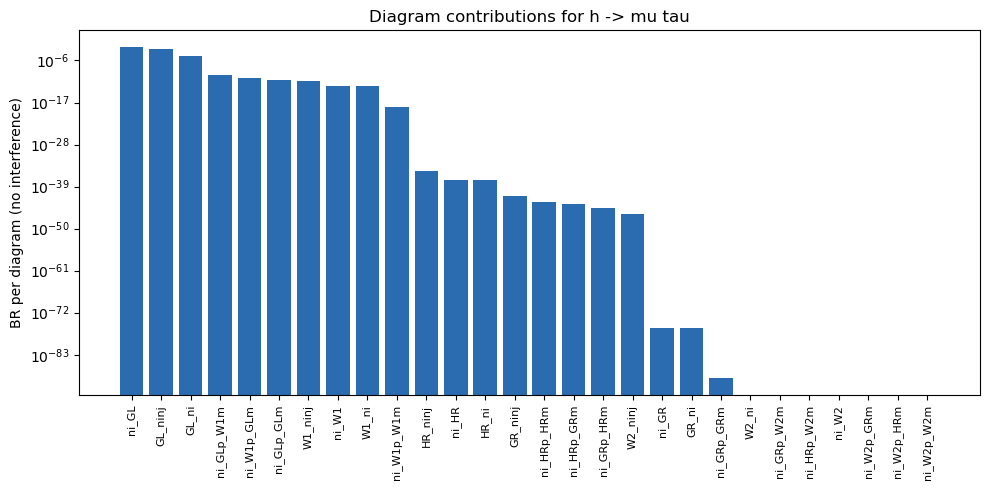

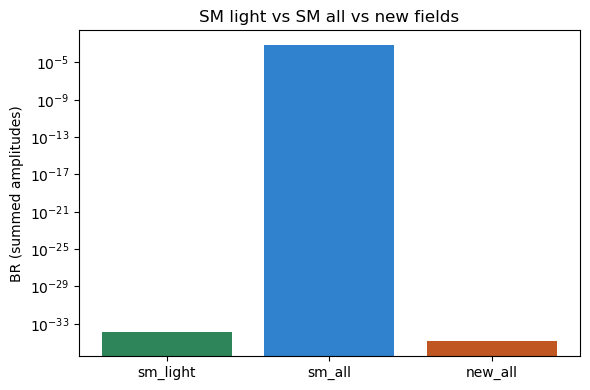

In [6]:
# Plot per-diagram BR contributions
names = [x[0] for x in diagram_results]
br_values = [x[2] for x in diagram_results]

plt.figure(figsize=(10, 5))
plt.bar(range(len(names)), br_values, color="#2b6cb0")
plt.yscale("log")
plt.xticks(range(len(names)), names, rotation=90, fontsize=8)
plt.ylabel("BR per diagram (no interference)")
plt.title("Diagram contributions for h -> mu tau")
plt.tight_layout()
plt.show()

# Compare SM (light-only) vs SM (all neutrinos) vs new fields (all neutrinos)
group_results = {}

if sm_diagrams:
    amps_sm_light = evaluator_sm_light.evaluate_sum(
        sm_diagrams, vR_point, YR_point, muX_point, mn_vals
    )
    width_sm_light = compute_partial_width(
        amps_sm_light["AL"], amps_sm_light["AR"], sm_params.mH,
        sm_params.lepton_masses[lepton_a],
        sm_params.lepton_masses[lepton_b],
    )
    group_results["sm_light"] = compute_br_from_width(
        width_sm_light, lfv_total_width=total_lfv_width_all
    )

if sm_diagrams:
    amps_sm_all = evaluator_all.evaluate_sum(
        sm_diagrams, vR_point, YR_point, muX_point, mn_vals
    )
    width_sm_all = compute_partial_width(
        amps_sm_all["AL"], amps_sm_all["AR"], sm_params.mH,
        sm_params.lepton_masses[lepton_a],
        sm_params.lepton_masses[lepton_b],
    )
    group_results["sm_all"] = compute_br_from_width(
        width_sm_all, lfv_total_width=total_lfv_width_all
    )

if new_field_diagrams:
    amps_new_all = evaluator_all.evaluate_sum(
        new_field_diagrams, vR_point, YR_point, muX_point, mn_vals
    )
    width_new_all = compute_partial_width(
        amps_new_all["AL"], amps_new_all["AR"], sm_params.mH,
        sm_params.lepton_masses[lepton_a],
        sm_params.lepton_masses[lepton_b],
    )
    group_results["new_all"] = compute_br_from_width(
        width_new_all, lfv_total_width=total_lfv_width_all
    )

group_results

# Plot comparison bars
group_names = list(group_results.keys())
group_brs = [group_results[name] for name in group_names]

plt.figure(figsize=(6, 4))
colors = ["#2f855a", "#3182ce", "#c05621"]
plt.bar(group_names, group_brs, color=colors[:len(group_names)])
plt.yscale("log")
plt.ylabel("BR (summed amplitudes)")
plt.title("SM light vs SM all vs new fields")
plt.tight_layout()
plt.show()

Interpretation:
 - It seems that SM contributions could be more important


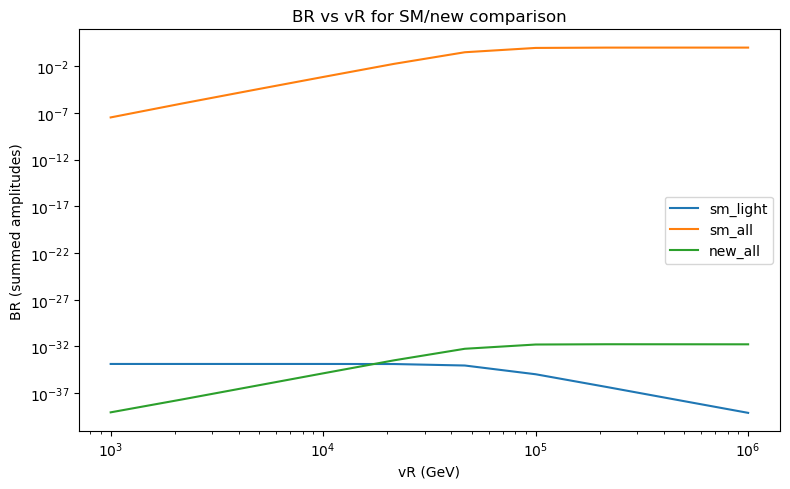

In [ ]:
# Plot of BR vs vR for each comparison group
vR_values = np.logspace(3, 6, 10)  # from 1 TeV to 1 PeV
group_brs_vs_vR = {"sm_light": [], "sm_all": [], "new_all": []}

for vR in vR_values:
    amps_total_all = evaluator_all.evaluate_sum(
        list(diagram_summed_all.keys()), vR, YR_point, muX_point, mn_vals
    )
    total_lfv_width_all = compute_partial_width(
        amps_total_all["AL"], amps_total_all["AR"], sm_params.mH,
        sm_params.lepton_masses[lepton_a],
        sm_params.lepton_masses[lepton_b],
    )
    if sm_diagrams:
        amps_sm_light = evaluator_sm_light.evaluate_sum(
            sm_diagrams, vR, YR_point, muX_point, mn_vals
        )
        width_sm_light = compute_partial_width(
            amps_sm_light["AL"], amps_sm_light["AR"], sm_params.mH,
            sm_params.lepton_masses[lepton_a],
            sm_params.lepton_masses[lepton_b],
        )
        group_brs_vs_vR["sm_light"].append(
            compute_br_from_width(width_sm_light, lfv_total_width=total_lfv_width_all)
        )
    if sm_diagrams:
        amps_sm_all = evaluator_all.evaluate_sum(
            sm_diagrams, vR, YR_point, muX_point, mn_vals
        )
        width_sm_all = compute_partial_width(
            amps_sm_all["AL"], amps_sm_all["AR"], sm_params.mH,
            sm_params.lepton_masses[lepton_a],
            sm_params.lepton_masses[lepton_b],
        )
        group_brs_vs_vR["sm_all"].append(
            compute_br_from_width(width_sm_all, lfv_total_width=total_lfv_width_all)
        )
    if new_field_diagrams:
        amps_new_all = evaluator_all.evaluate_sum(
            new_field_diagrams, vR, YR_point, muX_point, mn_vals
        )
        width_new_all = compute_partial_width(
            amps_new_all["AL"], amps_new_all["AR"], sm_params.mH,
            sm_params.lepton_masses[lepton_a],
            sm_params.lepton_masses[lepton_b],
        )
        group_brs_vs_vR["new_all"].append(
            compute_br_from_width(width_new_all, lfv_total_width=total_lfv_width_all)
        )

plt.figure(figsize=(8, 5))
for group_name, br_values in group_brs_vs_vR.items():
    if not br_values:
        continue
    plt.plot(vR_values, br_values, label=group_name)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("vR (GeV)")
plt.ylabel("BR $/h \\to \\mu \\tau)$")
plt.title("BR vs vR for SM/new comparison")
plt.legend()
plt.tight_layout()
plt.show()